# Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
DATA_FOLDER = "CREMA-D"
SAMPLERATE = 16000
FRAME_SIZE = 1280
HOP = 256
N_MELS = 28
N_FFT = 1280
N_MFCC = 13 

# Dataset

In [278]:
class CremaDDataset(torch.utils.data.Dataset):
    def __init__(self, dir, preprocessing=None):
        assert dir in ["train","validation","test"], "Conjunto invalido"
        self.dir = dir
        self.df = (pd.read_csv(os.path.join(DATA_FOLDER, 'labels.csv'))[lambda x: x['partition'] == f"{self.dir}"])
        self.preprocessing = preprocessing 
        
    def __getitem__(self,idx):
        signal_path = os.path.join(DATA_FOLDER,self.df.iloc[idx]["path"])
        waveform,_ = librosa.load(signal_path,sr=SAMPLERATE)
        label =  self.df.iloc[idx]["class"]
        if self.preprocessing is not None:
            not_padded_features = self.preprocessing.transform(waveform,pad=False)
            features = self.preprocessing.transform(waveform)
        else: 
            features = waveform
        
        return features,label, not_padded_features.size(0)
    
    def __len__(self):
        return len(self.df)


In [7]:
import torchaudio.functional as F
import torch
from src.utils.utils import get_MFCC


In [279]:
class Preprocessing:
    """
    Salen (n_windows,n_MFCC)
    """
    def __init__(self, frame_size, hop, n_mels, n_fft, n_mfcc, samplerate):
        self.samplerate=samplerate
        self.frame_size = frame_size
        self.hop = hop
        self.n_mels = n_mels
        self.n_fft = n_fft
        

        self.mfcc = get_MFCC(frame_size, 
                     hop, 
                     n_mels, 
                     n_fft,
                     n_mfcc, 
                     samplerate)
    
    def transform(self,waveform,pad=True):
        signal = torch.Tensor(waveform)
        features = self.mfcc(signal).T
        # Padding (no se procesa)
        if pad:
            zeros = torch.zeros(500-features.size()[0],features.size()[1])
                   
            features = torch.cat((features,zeros),dim = 0)  
        return features
    

In [280]:
p = Preprocessing(FRAME_SIZE, HOP, N_MELS, N_FFT, N_MFCC, SAMPLERATE)

In [281]:
dataset = CremaDDataset(dir = "train",preprocessing = p)

In [282]:
dataset[0]

(tensor([[-3.5713,  3.0809,  2.0625,  ...,  1.4525,  1.8131,  2.0151],
         [36.6516, 46.9749, 21.1307,  ..., -0.3892, -1.2355, -1.5876],
         [75.6386, 61.2862, 17.3726,  ...,  0.1340, -0.5726, -3.8236],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 5,
 143)

In [75]:
def get_larges(batch):
    list_larges = [batch[0].size()[0] for x in dataset]
    return list_larges


In [77]:
larges = get_larges()

In [10]:
dataset[0][0].shape

torch.Size([143, 13])

In [34]:
d = {}
for _,label in dataset:
    if label not in d.keys():
        d[label] = 1
    else:
        d[label]+=1
print(d)

{5: 879, 3: 879, 2: 879, 4: 879, 0: 752, 1: 879}


In [61]:
larges = []
for signal,_ in dataset:
    larges.append(signal.shape[0])

In [12]:
np.max(np.array(larges))

313

{'whiskers': [<matplotlib.lines.Line2D at 0x10ed87cc580>,
 'caps': [<matplotlib.lines.Line2D at 0x10ed87ccac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x10ed87cc2e0>],
 'medians': [<matplotlib.lines.Line2D at 0x10ed87cd000>],
 'fliers': [<matplotlib.lines.Line2D at 0x10ed87cd2a0>],
 'means': []}

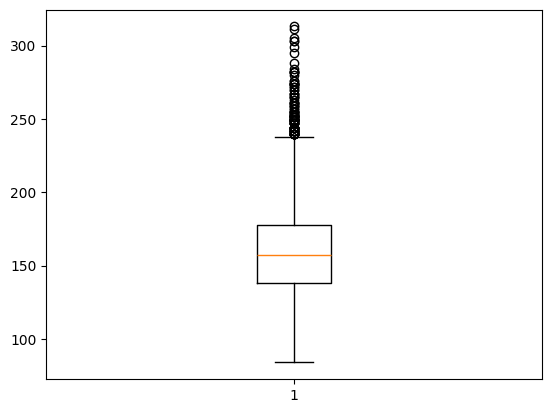

In [13]:
plt.boxplot(larges)

# LSTM

In [283]:
from torch.utils.data import DataLoader

p = Preprocessing(FRAME_SIZE, HOP, N_MELS, N_FFT, N_MFCC, SAMPLERATE)
dataset = CremaDDataset(dir="train",preprocessing=p)
dataloader = DataLoader(dataset,batch_size=64, shuffle=True)

In [303]:
# TODO: MLPCustom
import torch.nn.utils.rnn as rnn_utils
class HiddenLayer(nn.Module):
    """
    inputs:
    - hidden_dim: dimensión de entrada y salida de la capa.
    - dropout: probabilidad de dropout

    output: modulo con capas Linear, ReLU y Dropout.
    """
    def __init__(self, input_dim, output_dim, dropout):
        super(HiddenLayer, self).__init__()
        self.layer = nn.Linear(input_dim, output_dim)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        x0 = self.layer(x)
        x1 = self.activation(x0)
        out = self.dropout(x1)
        return out
    
class CustomMLP(nn.Module):
    def __init__(self,input_dim,output_dim,n_layers,dropout):
        super().__init__()
        hidden_dims = [input_dim//(2**k) for k in range(1,n_layers)]
        self.first = nn.Linear(input_dim,hidden_dims[0])
        self.hidden = nn.ModuleList([HiddenLayer(hidden_dims[k],hidden_dims[k+1],dropout) for k in range(len(hidden_dims)-1)]) #Cadena de capas ocultas
        self.out = nn.Linear(hidden_dims[-1],output_dim)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,x):
        x = self.first(x)
        for layer in self.hidden:
            x = layer(x)
        x = self.out(x)
        x = self.softmax(x)

        return x


class CustomLSTM(nn.Module):
    def __init__(self, input_size,hidden_size, num_lstm_layers,num_mlp_layers, output_size, dropout):
        super().__init__()

        # capa recurrente
        self.input_size = input_size
        self.lstm = torch.nn.LSTM(input_size=self.input_size, 
                                  hidden_size=hidden_size, 
                                  num_layers=num_lstm_layers, 
                                  batch_first=True,
                                  dropout = dropout)

        # capa fully conected
        self.fc = CustomMLP(input_dim = hidden_size,
                            output_dim = output_size,
                            n_layers = num_mlp_layers,
                            dropout = dropout)
        
    def forward(self, x, lengths):
        
        packed_input = rnn_utils.pack_padded_sequence(x,lengths,batch_first=True,enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = rnn_utils.pad_packed_sequence(packed_output,batch_first=True)
        valid_output = self.get_last_valid_output(output,lengths)
        mlp_output = self.fc(valid_output)
        return mlp_output
    
    def get_last_valid_output(self,output,lengths):
        batch_size = output.size(0)
        last_valid_output = []
        for i in range(batch_size):
            l = lengths[i]
            last_valid_output.append(output[i,l-1,:])
        return torch.stack(last_valid_output)
    
    

In [304]:
model = CustomLSTM(input_size = N_MFCC,
                   hidden_size = 128,
                   num_lstm_layers = 2,
                   num_mlp_layers = 3,
                   output_size = 6, 
                   dropout=0.2)

In [235]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CyclicLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
SEED=30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [306]:
class EngineLSTM:
    def __init__(self,input_size,hidden_size,num_lstm_layers,num_mlp_layers, output_size, dropout,batch_size,learning_rate,preprocessing):
        torch.manual_seed(SEED)
        self.model = CustomLSTM(input_size = input_size,
                                hidden_size = hidden_size,
                                num_lstm_layers = num_lstm_layers,
                                num_mlp_layers = num_mlp_layers,
                                output_size = output_size, 
                                dropout=dropout).to(DEVICE)
        self.batch_size = batch_size
        #self.optimizer = SGD(self.model.parameters(),lr=learning_rate,momentum=0.9) 
        self.preprocessing = preprocessing
        self.optimizer = Adam(self.model.parameters(),lr=learning_rate)
        #self.scheduler = CyclicLR(self.optimizer,base_lr=0.1*learning_rate,max_lr=learning_rate,step_size_up=1000)
        self.criterion = nn.CrossEntropyLoss()
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = np.inf
        self.acc = 0
        self.best_acc = 0
        
    def train(self,epochs,patience,delta,save_model=True):
        dataloader = DataLoader(CremaDDataset("train",self.preprocessing),batch_size=self.batch_size,shuffle=True)
        dataloader_eval = DataLoader(CremaDDataset("validation",self.preprocessing),shuffle=False)
        p = 0
        status = 0
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            val_loss = 0
            acc = 0 
            with tqdm(total=len(dataloader),desc=f'Epoca {epoch}/{epochs}',unit="batch") as pbar:
                for batch in dataloader:
                    self.optimizer.zero_grad()
                    input,label,lengths = batch[0].float().to(DEVICE),batch[1].type(torch.uint8).to(DEVICE), batch[2]
                    
                    pred = self.model(input,lengths)
                    label_pred = torch.argmax(pred,dim=1)

                    
                    t_loss = self.criterion(pred,label)
                    train_loss +=t_loss.item()  #Acumulo losses por época
                    t_loss.backward()   #Propago loss en cada batch

                    self.optimizer.step()   #Step en cada batch
                    #self.scheduler.step()
                    pbar.update(1)
            train_loss = train_loss/len(dataloader)
            self.train_losses.append(train_loss)

            self.model.eval()
            with torch.no_grad():
                for batch in tqdm(dataloader_eval, total=len(dataloader_eval),desc="Validación"):
                    input,label,lengths = batch[0].float().to(DEVICE),batch[1].type(torch.uint8).to(DEVICE), batch[2]
                    pred = self.model(input,lengths)
                    label_pred = torch.argmax(pred,dim=1)

                    val_loss += self.criterion(pred,label).item()
                    acc += (label_pred==label).sum()
                
                val_loss = val_loss/len(dataloader_eval)
                acc = acc/len(dataloader_eval)
                self.acc = acc
            
            
            self.val_losses.append(val_loss)

            print("Epoca: {}, \tTrain_loss: {:.4f}, \tVal loss: {:.4f}, \tAcc: {:.4f}".format(epoch,train_loss,val_loss,acc))
            if acc > self.best_acc:
                self.best_acc = acc
                if save_model:
                    self.save_model()
            if val_loss+delta<self.best_val_loss:
                self.best_val_loss = val_loss
                self.acc = acc
                p = 0
            else:
                p+=1
            
            if p==patience:
                self.train_losses = self.train_losses[:-patience]
                self.val_losses = self.val_losses[:-patience]
                status = 1
                print("Patience alcanzada, terminando entrenamiento")
                break
        if status == 0:
            print("El entrenamiento ha concluido dado que se llegó a las épocas")

    def evaluate(self,dataloader):
        self.model.eval()
        acc = 0
        real_labels = []
        pred_labels = []
        with torch.no_grad():
            for batch in tqdm(dataloader, total=len(dataloader),desc="Evaluación"):
                input,label = batch[0].float().to(DEVICE),batch[1].type(torch.uint8).to(DEVICE)
                
                pred = self.model(input)
                label_pred = torch.argmax(pred,dim=1)
                real_labels.append(label.cpu())
                pred_labels.append(label_pred.cpu())
                acc += (label_pred==label).sum()
            acc = acc/len(dataloader)
            conf_matrix = confusion_matrix(y_true = real_labels,
                                             y_pred = pred_labels,
                                             normalize='true')
            sns.heatmap(conf_matrix,annot=True,cmap="summer")
            plt.xlabel("Valores predichos")
            plt.ylabel("Valores reales")
            plt.show()
            print(f"Accuracy: {acc}")
        
    def save_model(self):
        torch.save(self.model.state_dict(), "model.pth")

    def load_model(self,path):
        self.model.load_state_dict(torch.load(path))

    def return_losses(self):
        return [self.train_losses, self.val_losses]
    
    def return_acc(self):
        return self.acc

In [307]:
e = EngineLSTM(input_dim=N_MFCC,hidden_dim=128,num_layers=2,D_out=6,batch_size=64,learning_rate=0.01,preprocessing=p)

TypeError: EngineLSTM.__init__() got an unexpected keyword argument 'input_dim'

In [308]:
e = EngineLSTM(input_size = N_MFCC,
               hidden_size = 128,
               num_lstm_layers = 2,
               num_mlp_layers = 3, 
               output_size = 6, 
               dropout = 0.2,
               batch_size = 64,
               learning_rate = 0.001,
               preprocessing = p)

In [311]:
e.train(epochs=100,patience=15,delta=0.01)

Validación: 100%|██████████| 1475/1475 [00:32<00:00, 45.14it/s]


Epoca: 0, 	Train_loss: 1.6185, 	Val loss: 1.6180, 	Acc: 0.4115


Validación: 100%|██████████| 1475/1475 [00:27<00:00, 53.21it/s]


Epoca: 1, 	Train_loss: 1.6326, 	Val loss: 1.6154, 	Acc: 0.4102


Validación: 100%|██████████| 1475/1475 [00:29<00:00, 49.32it/s]


Epoca: 2, 	Train_loss: 1.6431, 	Val loss: 1.6380, 	Acc: 0.3993


Validación: 100%|██████████| 1475/1475 [00:28<00:00, 51.50it/s]


Epoca: 3, 	Train_loss: 1.6260, 	Val loss: 1.6108, 	Acc: 0.4210


Epoca 4/100:  31%|███       | 25/81 [00:12<00:28,  1.96batch/s]


KeyboardInterrupt: 